## Just run throught cell 1-4 and read carefully about cell 5 and 6

In [1]:
new = False
if new:
    !git clone -q https://github.com/yzluka/ritm_interactive_segmentation.git
    !pip3 install -q -r ./ritm_interactive_segmentation/requirements.txt

# CHOOSE MODEL HERE
# possible choices are: coco_lvis_h18s_itermask,  coco_lvis_h18_baseline, coco_lvis_h18_itermask,
# coco_lvis_h18_itermask, sbd_h18_itermask

MODEL_NAME = "cocolvis_icl_vit_huge"
URL_PREFIX_FBRS = "https://github.com/saic-vul/fbrs_interactive_segmentation/releases/download/v1.0"
URL_PREFIX_RITM = "https://github.com/saic-vul/ritm_interactive_segmentation/releases/download/v1.0"
DATA_FOLDER = "./ritm_interactive_segmentation/datasets" 
WEIGHTS_FOLDER = "./CFR-ICL-Interactive-Segmentation/weights"
WEIGHTS_URL = f"{URL_PREFIX_RITM}/{MODEL_NAME}.pth"

# Evaluation datasets are stored in another repository

if new:
    !mkdir -p {DATA_FOLDER}
    !mkdir -p {WEIGHTS_FOLDER}

    !wget -q -P {WEIGHTS_FOLDER} {WEIGHTS_URL}

    for dataset in ['GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal']:
        dataset_url = f"{URL_PREFIX_FBRS}/{dataset}.zip"
        dataset_path = f"{DATA_FOLDER}/{dataset}.zip"
        !wget -q -O {dataset_path} {dataset_url}
        !unzip -q {dataset_path} -d {DATA_FOLDER}
        !rm {dataset_path}


In [2]:
%cd CFR-ICL-Interactive-Segmentation/
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import torch
import numpy as np

sys.path.insert(0, './')

from isegm.utils import vis, exp
from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample

device = torch.device('cuda:0')
cfg = exp.load_config_file('./config.yml', return_edict=True)
DATASET = 'GrabCut'
dataset = utils.get_dataset(DATASET, cfg)

/data/SAM/CFR-ICL-Interactive-Segmentation


In [3]:
from isegm.inference.predictors import get_predictor

EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, MODEL_NAME)
model = utils.load_is_model(checkpoint_path, device,eval_ritm=False)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'NoBRS'

zoom_in_params = {
                'skip_clicks': -1,
                'target_size': (448, 448)
            }

predictor_params = {
        'cascade_step': 4 + 1,
        'cascade_adaptive': True,
        'cascade_clicks': 1
}

predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH,\
                          predictor_params=predictor_params, zoom_in_params=zoom_in_params)


/home/yz696/.local/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[0.9794069 0.9804768 0.9823893 0.9857379]


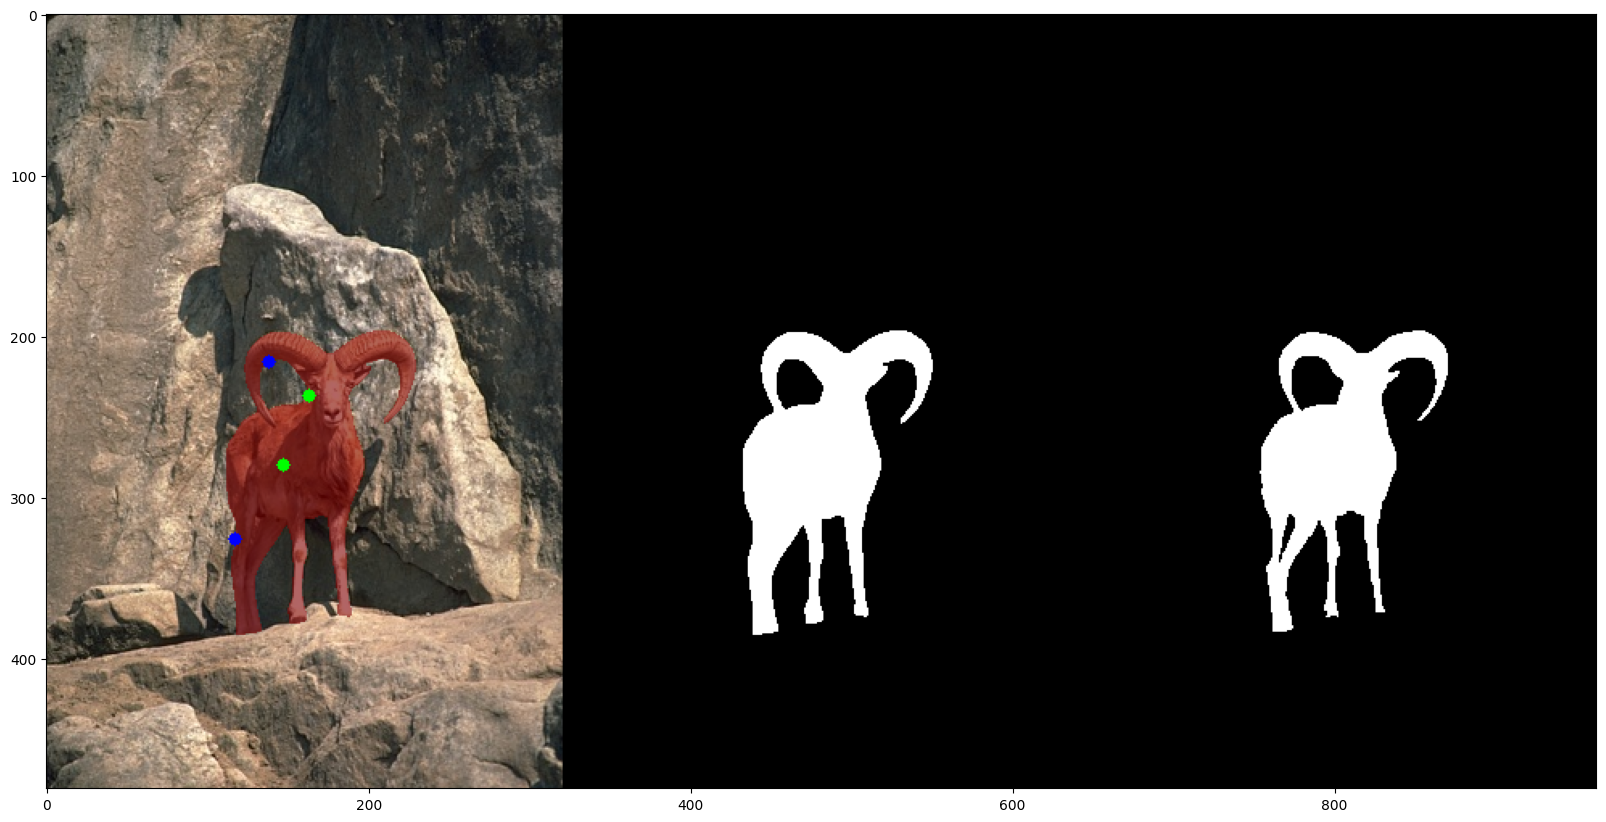

In [4]:
from isegm.inference.clicker import Click
from isegm.inference.evaluation import evaluate_sample

sample_id = 12
TARGET_IOU = 0.985

sample = dataset.get_sample(sample_id)
gt_mask = sample.gt_mask()

clicks_list, ious_arr, pred = evaluate_sample(sample.image, gt_mask, predictor, 
                                              pred_thr=MODEL_THRESH, 
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)

pred_mask = pred > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample.image, mask=pred_mask, clicks_list=clicks_list)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

print(ious_arr)

plt.figure(figsize=(20, 30))
plt.imshow(draw)
plt.show()


In [5]:
click_list1 = []
click_list1.append(Click(is_positive=True, coords=(280,147),indx=0))
click_list1.append(Click(is_positive=True, coords=(237,163),indx=1))
click_list1.append(Click(is_positive=False, coords=(216,138),indx=2))
click_list1.append(Click(is_positive=False, coords=(326,117),indx=3))

[0.9794069192751236, 0.9804767776407727, 0.982389289392379, 0.9857379082265398]


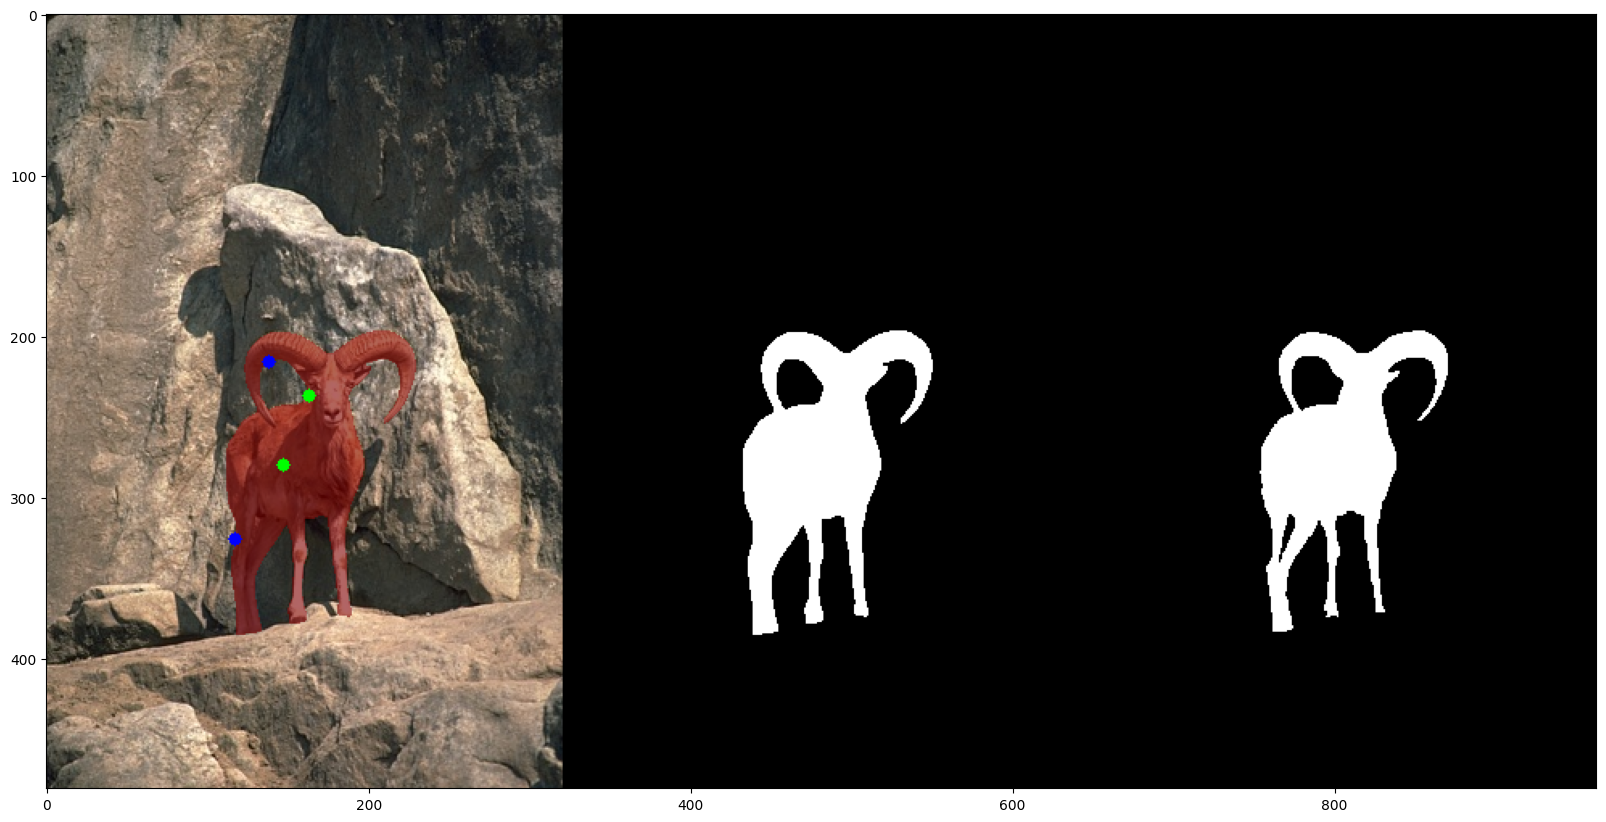

In [7]:
from isegm.inference.evaluation import evaluate_sample_onepass

sample_id = 12
TARGET_IOU = 0.95

sample = dataset.get_sample(sample_id)
gt_mask = sample.gt_mask()

###################################################
# input:
# sampel.image: a RGB image as np array
# gt_mask:      a binary mask
# predictor：   define before as the model 
# click_list1:  a list of Click object defined before
# pred_thr:     a constant, set as 0.49
# iterative:    using the OEM iterative msk generation method
# Note: setting 'iterative' to False may produce masks 
# with worse quality in some multi-point scenarious
# ###############################################
# output:
# pred_mask: the actual predicted mask
# msk_prob: the probability may of the mask
# iou: the iou between pred_mask and gt_mask
###################################################

pred_mask,msk_prob, ious = evaluate_sample_onepass(sample.image, gt_mask, predictor,click_list1,\
                                                  pred_thr=MODEL_THRESH, iterative=True)

pred_mask = msk_prob > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample.image, mask=pred_mask, clicks_list=click_list1)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

print(ious)

plt.figure(figsize=(20, 30))
plt.imshow(draw)
plt.show()


In [5]:
from isegm.inference.clicker import Click
from isegm.inference.evaluation import evaluate_sample_onepass
##############################################################
# suppose you turn all points into a list as points_coordinate = [[x0,y0],[x1,y1],[x2,y2],...., [xN,yN]]
# for each point, you need to convert it to a click object
# Click(is_positive, coords, indx)
# is_positive=Ture if the point is for object;
# is_positive=False if the point is for background;
# coords, unlike in SAM, takes the (y, x) form "i.e, (row_id, column_id)"
# index is option, but whatever
##############################################################
click_list1 = []
click_list1.append(Click(is_positive=True, coords=(280,147),indx=0))
click_list1.append(Click(is_positive=True, coords=(205,144),indx=1))
click_list1.append(Click(is_positive=False, coords=(315,172),indx=2))



ImportError: cannot import name 'evaluate_sample_onepass' from 'isegm.inference.evaluation' (/data/SAM/CFR-ICL-Interactive-Segmentation/./isegm/inference/evaluation.py)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0.96001221001221


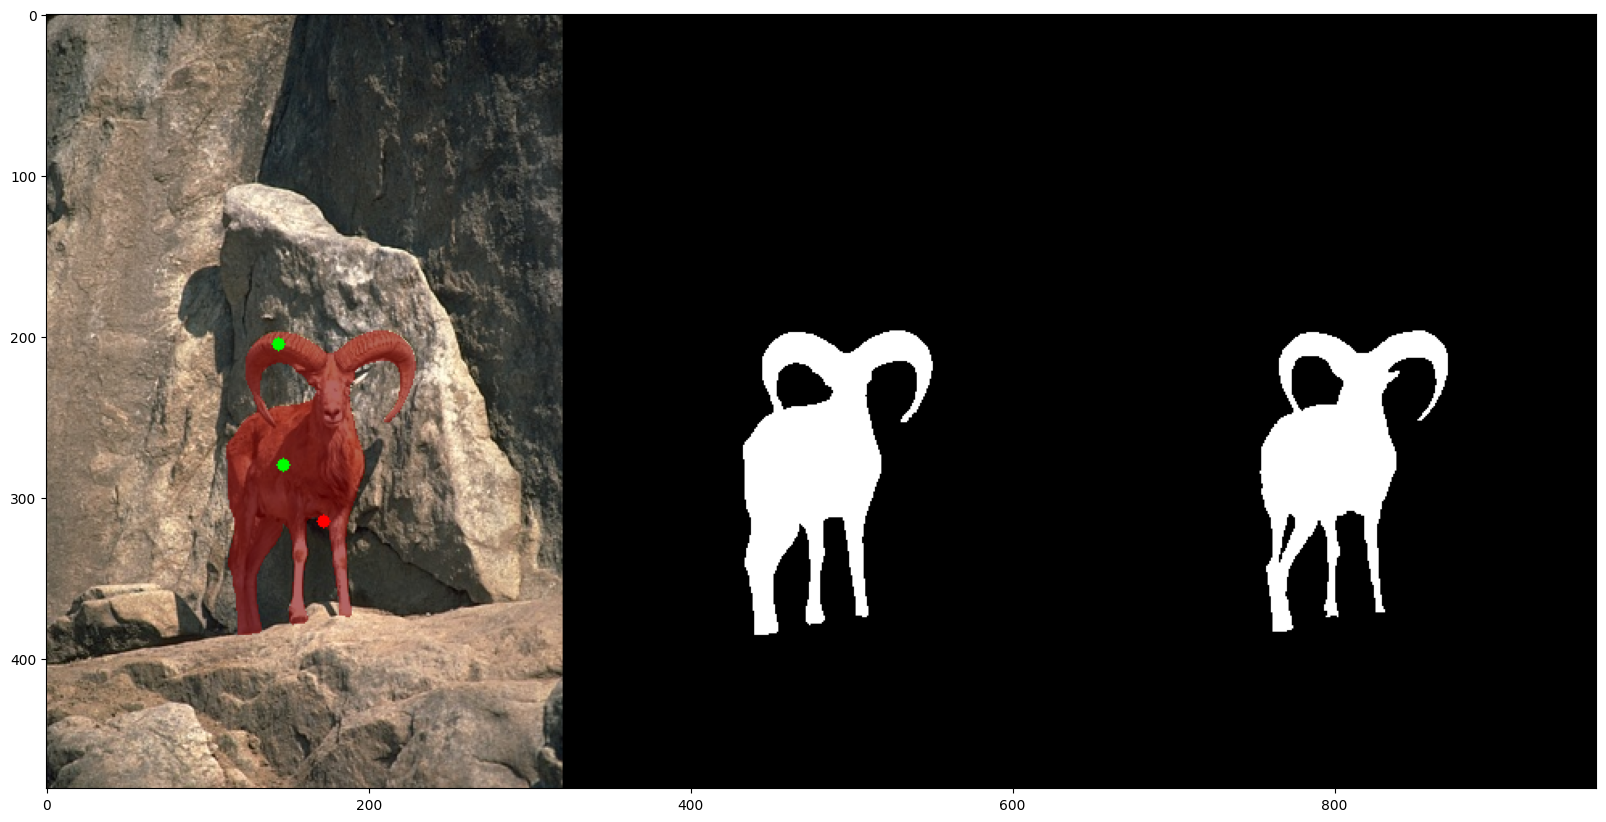

In [6]:

sample_id = 12
TARGET_IOU = 0.95

sample = dataset.get_sample(sample_id)
gt_mask = sample.gt_mask

###################################################
# input:
# sampel.image: a RGB image as np array
# gt_mask:      a binary mask
# predictor：   define before as the model 
# click_list1:  a list of Click object defined before
# pred_thr:     a constant, set as 0.49
# iterative:    using the OEM iterative msk generation method
# Note: setting 'iterative' to False may produce masks 
# with worse quality in some multi-point scenarious
# ###############################################
# output:
# pred_mask: the actual predicted mask
# msk_prob: the probability may of the mask
# iou: the iou between pred_mask and gt_mask
###################################################

pred_mask,msk_prob, ious = evaluate_sample_onepass(sample.image, gt_mask, predictor,click_list1,\
                                                  pred_thr=MODEL_THRESH, iterative=True)

pred_mask = msk_prob > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample.image, mask=pred_mask, clicks_list=click_list1)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

print(ious)

plt.figure(figsize=(20, 30))
plt.imshow(draw)
plt.show()